# Falcon API: Real-Time Bitcoin Analysis

#### Author: Emily Castelan Moreno
#### DATA605 Spring 2025

-----------------------------------------------------------------------------------------------------------------------

**Notebook is served on Jupyter Server (port 8889)**  
To access it in VS Code or a browser, paste the following URL: http://localhost:8889/

### Project Description:
This notebook demonstrates a real-time and near real-time Bitcoin trade data ingestion pipeline. This notebook utilizes the Falcon API system designed in the app. The app integrates a persistent WebSocket connection, a Falcon API server, Redis and Redis TimeSeries-backed Celery workers, and container orchestration. This setup required extensive debugging across async message flows, Redis compatibility, and Docker networking.

### High Level System Overview
```
1. Notebook
   |
   |  (HTTP POST to Falcon API /route/resource)
   ▼
2. Falcon API (e.g., KlineIngestResource or LSTM endpoints)
   |
   |  (Dispatch task via Celery .apply_async)
   ▼
3. Celery Worker
   |
   |  (Runs Python logic: process, train, or predict)
   ▼
4. RedisTimeSeries
   |
   |  - Stores ingested candles
   |  - Serves input to models
   ▼
5. Notebook
   |
   |  ← Receives predictions or anomaly results

```

This setup enables scalable, asynchronous prediction calls that can be triggered from a notebook, dashboard, or API client, while keeping the model execution offloaded to background workers.

-----------------

In [14]:
# Use this code block to restart the Jupyter Notebook cache.
%load_ext autoreload
%autoreload 2

# Once set up use: %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Environment Setup

The docker_config folder contains all files needed to build the services required for the app and this Notebook.
The docker_config utilizes:
* requirements.txt = all Python packages, and versions for compatability
* docker-compose.yml = coordinates 6 docker containers on a custom bridge network
* DockerFile = defines the base image for all Falcon system components
* start_services.sh = shell script containts the entry point for falcon_api and launches Jupyter server on port `8889`

In [ ]:
"""
Notebook Requirements to run Falcon app
"""

##########################################
# Standard Library Imports
##########################################
from datetime import datetime, timedelta
import importlib
import json

##########################################
# Third-Party Imports
##########################################
import numpy as np
import requests
import redis
import celery
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from typing import Sequence
import matplotlib.pyplot as plt


##########################################
# Local Module Imports
##########################################
import Falcon_functions
from Falcon_functions import reset_timeseries_keys
from Falcon_utils import train_lstm_and_save, load_lstm_and_predict
from Falcon_Celery_Tasks_lstm import train, predict

# Reload Falcon_functions in case it was modified
importlib.reload(Falcon_functions)

##########################################
# Initialization
##########################################
reset_timeseries_keys("coinbase", "btc_usd", "1d")
# This will reset the keys and set the duplicate policy to be the last timestamp input 


[RESET] Deleted key: ts:coinbase:btc_usd:1d:open
[RESET] Deleted key: ts:coinbase:btc_usd:1d:high
[RESET] Deleted key: ts:coinbase:btc_usd:1d:low
[RESET] Deleted key: ts:coinbase:btc_usd:1d:close
[RESET] Deleted key: ts:coinbase:btc_usd:1d:volume
[RESET] Re-created key: ts:coinbase:btc_usd:1d:open with DUPLICATE_POLICY=last
[RESET] Re-created key: ts:coinbase:btc_usd:1d:high with DUPLICATE_POLICY=last
[RESET] Re-created key: ts:coinbase:btc_usd:1d:low with DUPLICATE_POLICY=last
[RESET] Re-created key: ts:coinbase:btc_usd:1d:close with DUPLICATE_POLICY=last
[RESET] Re-created key: ts:coinbase:btc_usd:1d:volume with DUPLICATE_POLICY=last


---

# Source Historical Data (Candles)

This notebook uses the Falcon endpoint defined in `Falcon_ingest_endpoint2.py` to source historical Bitcoin candle data.  
Candles are a standard format in financial trading that summarize market activity over a time interval. Each candle includes the following:  
**Open:** the price at the beginning of the interval  
**High:** the highest price during the interval  
**Low:** the lowest price during the interval  
**Close:** the price at the end of the interval  
**Volume:** the total trading volume during the interval  

The `resolution` is the interval of time, which Coinbase expects to be in seconds. A resolution map is defined and utilized to set parameters for the user to facilitate easier and practical models.  
**1m:** 60 sec  
**5m":** 300 sec  
**15m":** 900 sec  
**1h":** 3600 sec  
**1d":** 86400 sec  
These features are well-suited for training machine learning models to predict future prices or detect anomalies.  
The Falcon API routes incoming data through multiple Celery workers, which handle:  
* Processing incoming candles  
* Training LSTM models  
* Generating predictions  
* Intermediate results are cached in Redis for fast access and reusability  

Each call to select_candles retrieves a set of candle data from the Coinbase API, identified by the symbol BTC-USD, and stores it under a unique model_id.

In [16]:
from datetime import datetime,timedelta
'''select_candles
Function facilitates building the payload and requests it to the Falcon endpoint
Parameters: 
    start time = input by user in datetime
    end time = input by user in datetime
    model id = redis db cache index
    symbol = type of cryptocurrency
    resolution = interval of time refer to RESOLUTION_MAP
    url = default set to Falcon endpoint
Returns:
    json response, confirms process was successful:
        Response: {'platform': 'coinbase', 'msg': 'Processing: {number} candles'}
'''
# Define endpoint.
def select_candles(start_time, end_time, model_id, symbol, resolution, url="http://falcon_api:8888/ingest/kline/coinbase"):
    # Convert to ISO 8601 strings.
    # because your Falcon endpoint expects timestamp inputs in ISO 8601 format.
    start_iso = start_time.isoformat() + "Z"
    end_iso = end_time.isoformat() + "Z"

    # Build payload.
    payload = {
        "model_id": model_id,
        "symbol": symbol,
        "resolution": resolution,
        "start": start_iso,
        "end": end_iso
    }
 
    # Send POST request to Falcon endpoint. 
    response = requests.post(url, json=payload)

    # Output response.
    print("Status:", response.status_code)
    return response.json()

### Load 4 Sets of Candle Data 
To evaluate model performance under different historical conditions and time resolutions, we pull Bitcoin candle data using the `select_candles()` function across four distinct time periods.
These cases are designed to expose the model to a variety of market behaviors including price spikes and dips.  

**Case 1** — 1 Day of Hourly Candles (model_id=2)  
Recent market data sampled at a fine resolution of 1-hour intervals.  
Useful for testing short-term prediction and system responsiveness.  

**Case 2** — 30 Days of Daily Candles (model_id=3)  
One month, the past 30 days, of daily candles to train models on medium-term patterns.  

**Case 3** — 60-Day Bear Period: Jan–Mar 2020 (model_id=4)   
Captures a market downturn during early COVID-19 period to test performance under low price conditions. 

**Case 4** — 60-Day Bull Period: Feb–Apr 2024 (model_id=5)   
Represents a high-growth window to evaluate how the model performs under upward momentum.

Each of the 4 cases are callted twice to demonstrate different features in this Notebook.


In [17]:

####################################################################################
####################################################################################
# SECOND SET OF DATA PULLS FOR SAME 4 CASES 
####################################################################################
####################################################################################
# A second set of data pulls are called for the purposes of demonstrating the app features 
##################################################
# Case 1: Last 24 hours from now (2ND ITERATION)
##################################################
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=1)
# one day
select_candles(start_time,
            end_time,
            model_id=6,
            symbol="BTC-USD",
            resolution="1h")
##########################################
# Case 2: Last 30 days from now (2ND ITERATION)
##########################################
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)
# thirty days
select_candles(start_time,
            end_time,
            model_id=7,
            symbol="BTC-USD",
            resolution="1d")
##########################################
# Case 3: 60 days from Jan 2020 to March 2020 (2ND ITERATION)
##########################################
# 60 days low Jan 2020 to March 2020
end_time = datetime(2020, 3, 1)
start_time = end_time - timedelta(days=60)
select_candles(start_time,
            end_time,
            model_id=8,
            symbol="BTC-USD",
            resolution="1d")
##########################################
# Case 4: 60 days from Feb 2024 to April 2024 (2ND ITERATION)
##########################################
# 60 day high Feb to April 2024
end_time = datetime(2024, 2, 1)
start_time = end_time - timedelta(days=60)
select_candles(start_time,
            end_time,
            model_id=9,
            symbol="BTC-USD",
            resolution="1d")

Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200
Status: 200


{'platform': 'coinbase', 'msg': 'Processing: 60 candles'}

---

# Train LSTM Models On Historical Data

To forecast the future price of Bitcoin, this system uses Long Short-Term Memory (LSTM) models. LSTM is a type of recurrent neural network (RNN), which is ideal for modeling financial data due to the time series format. In this first version, the LSTM is designed to predict only the next closing price in the sequence, based on a sliding window of past values.

The pipeline uses the Falcon API to offload training to a Celery worker. Users can call the train_models() function, which sends a training request to the endpoint `/lstm/train`.

---

# Train LSTM Model to Predict n Steps into the Future

In addition to single-step forecasting, this notebook supports multi-step prediction, allowing the model to forecast n future time steps in a single forward pass. This is crucial for building practical financial forecasting tools, where anticipating multiple future prices is often more valuable than just predicting the next one.  
There are two main strategies for performing multi-step predictions with LSTMs:  
1. **Recursive Prediction**  
Predict one step ahead, then feed that prediction back into the input sequence to predict the next, repeating this process n times.  
Drawback: Accumulates error over time and increases memory/compute cost due to repeated forward passes.  
2. **Direct Multi-Output Prediction (Selected Approach)**
Train the LSTM to output all n future values in a single pass.
Achieved using a RepeatVector to LSTM to  TimeDistributed, Dense, architecture.  
Benefits: Faster and more memory-efficient, avoids compounding error.   

This implementation uses the second approach to build a direct multi-output LSTM that learns to forecast a fixed number of future values without recursion. The model takes a sliding window of past `seq_len` prices and directly predicts the next `nsteps` values in one batch.

In [ ]:
'''train_models_n
Function facilitates trains a multi-step LSTM model using time series data from RedisTimeSeries.
    Parameters:
        model_name (str): Name to assign the trained model and normalization config.
        symbol (str): Asset symbol in the format expected by Redis, expected bitcoin
        resolution (str): Time resolution of the candle data, refer to RESOLUTION_MAP.
        seq_len (int): Number of historical time steps used as input.
        model_id (int): Redis database ID to pull data from, should match data pull.
        nsteps (int): Number of future time steps to predict.
        training_epochs (int): Number of epochs to train the LSTM model.

    Returns:
        list: A list containing:
            - model (keras.Model): The trained Keras LSTM model.
            - min_val (float): Minimum value from the original time series.
            - max_val (float): Maximum value from the original time series.
'''
def train_models_n(model_name, symbol,resolution ,seq_len, model_id, nsteps, training_epochs,
                    url="http://falcon_api:8888/lstm/trainnsteps"):
    # Build payload
    payload = {
    "model_name": model_name,
    "symbol": symbol,
    "resolution": resolution,
    "seq_len": seq_len,
    "model_id":model_id,
    "nsteps":nsteps,
    "training_epochs": training_epochs
    } 
    response = requests.post(url, json=payload)

    # Output response 
    print("Status:", response.status_code)
    return response.json()

In [ ]:
# Use the train_models_n on the 4 examples.
# Parameters: model_name, symbol,resolution ,seq_len, model_id, nsteps, training_epochs
# Returns: json message 

##########################################
# Case 1: Last 24 hours from now TRAIN N_STEPS
##########################################
train_model_1day_n = train_models_n(
    "model_1dx", # model_name
    "btc_usd",   # symbol
    "1h",        # resolution
    10,          # sequence length
    6,           # RedisTS db as model_id
    10,          # nsteps
    5            # training_epochs
)

##########################################
# Case 2: Last 30 days from now TRAIN N_STEPS
##########################################
train_model_30day_n = train_models_n(
    "model_30dayx",
    "btc_usd",
    "1d",
    10,
    7,
    10,
    5
)
##########################################
# Case 3: 60 days from Jan 2020 to March 2020 TRAIN N_STEPS
##########################################
train_model_60daylow_n = train_models_n(
    "model_60daylowx",
    "btc_usd",
    "1d",
    10,
    8,
    10,
    5
)
##########################################
# Case 4: 60 days from Feb 2024 to April 2024 TRAIN N_STEPS
##########################################s
train_model_60dayhigh_n = train_models_n(
    "model_60dayhighx",
    "btc_usd",
    "1d",
    10,
    9,
    10,
    5
)
##########################################
# Confirm the model trained a price on the right redis db with the right number of steps
##########################################s
print(train_model_1day_n)
print(train_model_30day_n)
print(train_model_60daylow_n)
print(train_model_60dayhigh_n)

Status: 200
Status: 200
Status: 200
Status: 200
{'msg': 'Training 6 for 10 steps'}
{'msg': 'Training 7 for 10 steps'}
{'msg': 'Training 8 for 10 steps'}
{'msg': 'Training 9 for 10 steps'}


---

# Use LSTM Models to Predict Bitcoin Prices n steps into the Future

Once a multi-output LSTM model has been trained, it can be used to generate predictions for multiple future time steps using only the most recent historical data. This section utilizes a `predict_models_n` function to facilitate predicting for the user. Because this app uses the **Direct Multi-Output Prediction**, the number of steps cannot be defined at this point, it must have already been set at the train step.

In [ ]:
'''predict_models_n
Function facilitates making requests to the Falcon API endpoint to predict n steps ahead. This function sends a JSON payload to 
the `/lstm/predictnsteps` Falcon endpoint.

    Note:
        Because this system uses the Direct Multi-Output Prediction strategy,
        the number of prediction steps `nsteps` is fixed during training 
        and cannot be set at inference time.

    Parameters:
        model_name (str): Name of the trained model to load.
        symbol (str): Asset symbol to query, bitcoin expected.
        resolution (str): Time resolution of the input data, refer to RESOLUTION_MAP.
        seq_len (int): Number of historical time steps used as input.
        model_id (int): Redis database ID for selecting the corresponding dataset.
        url (str): Falcon endpoint for multi-step prediction (default: http://falcon_api:8888/lstm/predictnsteps).

    Returns:
        dict: JSON response containing predicted values and any returned metadata.

'''
def predict_models_n(model_name, symbol,resolution ,seq_len, model_id,
                    url="http://falcon_api:8888/lstm/predictnsteps"):
    # Build payload
    payload = {
    "model_name": model_name,
    "symbol": symbol,
    "resolution": resolution,
    "seq_len": seq_len,
    "model_id":model_id
    } 
    response = requests.post(url, json=payload)

    # Output response 
    #print("Status:", response.status_code)
    return response.json()

Utilize the function above `predict_models_n` on the 4 use cases.

In [ ]:
##########################################
# Case 1: Last 24 hours from now PREDICT N_STEPS
##########################################
predict_model_1day_n = predict_models_n(
    "model_1dx",
    "btc_usd",
    "1h",
    10,
    6
)
##########################################
# Case 2: Last 30 days from now PREDICT N_STEPS
##########################################
predict_model_30day_n = predict_models_n(
    "model_30dayx",
    "btc_usd",
    "1d",
    10,
    7
)
##########################################
# Case 3: 60 days from Jan 2020 to March 2020 PREDICT N_STEPS
##########################################
predict_model_60daylow_n = predict_models_n(
    "model_60daylowx",
    "btc_usd",
    "1d",
    10,
    8
)
##########################################
# Case 4: 60 days from Feb 2024 to April 2024 PREDICT N_STEPS
##########################################s
predict_model_60dayhigh_n = predict_models_n(
    "model_60dayhighx",
    "btc_usd",
    "1d",
    10,
    9
)
##########################################
# Confirm the model predicted a price on the right redis db with the right number of steps
##########################################s
print(predict_model_1day_n["msg"])
print(predict_model_1day_n["price"])
predicted_price1d = predict_model_1day_n["price"] 
print("======================================")
print(predict_model_30day_n["msg"])
print(predict_model_30day_n["price"])
predicted_price30d = predict_model_30day_n["price"] 
print("======================================")
print(predict_model_60daylow_n["msg"])
print(predict_model_60daylow_n["price"])
predicted_price60daylow_n = predict_model_60daylow_n["price"] 
print("======================================")
print(predict_model_60dayhigh_n["msg"])
print(predict_model_60dayhigh_n["price"])
predicted_price60dayhigh_n = predict_model_60dayhigh_n["price"] 


Predicted prices [102390.78915806879, 102518.17623740397, 102632.52091531582, 102732.17651049986, 102817.13076623276, 102888.32072164997, 102947.16803030147, 102995.27851248234, 103034.25754623473, 103065.60544294656] for model: 6 in increments of 1h
[102390.78915806879, 102518.17623740397, 102632.52091531582, 102732.17651049986, 102817.13076623276, 102888.32072164997, 102947.16803030147, 102995.27851248234, 103034.25754623473, 103065.60544294656]
Predicted prices [87135.28275579095, 88510.49148027539, 89542.17188539803, 90325.30703577399, 90926.28857447744, 91391.71520640016, 91754.754986099, 92039.42651014209, 92263.45368001342, 92440.1386245966] for model: 7 in increments of 1d
[87135.28275579095, 88510.49148027539, 89542.17188539803, 90325.30703577399, 90926.28857447744, 91391.71520640016, 91754.754986099, 92039.42651014209, 92263.45368001342, 92440.1386245966]
Predicted prices [7131.010744933859, 7268.236630150378, 7389.223159735054, 7494.191176405549, 7584.183039409071, 7660.6369

---

# Pull Actual Bitcoin Prices

After generating multi-step price predictions using the LSTM model, the next step is to evaluate the accuracy of those forecasts by comparing them to the actual Bitcoin prices observed during the same time window.

To do this, we use the manual_fetch() function, which directly queries the Coinbase API for historical candle data based on a specified symbol, resolution, and date range. This function supports flexible retrieval of any price component (open, high, low, close, or volume), and it returns a list of up to nsteps values sorted from oldest to newest.

In [57]:
# Get the actual historical candle values of the candle predicted 
#####################################
# Function pulls candles from API directly
####################################
# Corresponds to evaluating: 60 days low Jan 2020 to March 2020
RESOLUTION_MAP = {
    "1m": 60,
    "5m": 300,
    "15m": 900,
    "1h": 3600,
    "1d": 86400 
    }
''' 
Fetch up to nsteps candles from Coinbase and return a list of the requested price field.
Parameters:
- start:    YYYYMMDD string for the start of the interval (inclusive)
    - end:      YYYYMMDD string for the end of the interval (exclusive)
    - symbol:   
    - price_type: ["open", "high", "low", "close", "volume"]
    - resolution: RESOLUTION_MAP.keys()
    - nsteps:   number of candles to return 

    Returns:
    - List of floats oldest to newest
'''
def manual_fetch(
        start: str,
        end: str,
        symbol: str,
        price_type: str,
        resolution: str,
        nsteps: int
        ):
    # Allow user to input in YYYYMMDD format.
    start_dt = datetime.strptime(start, "%Y%m%d")
    end_dt   = datetime.strptime(end,   "%Y%m%d")

    # Use resolution map to get seconds.
    gran = RESOLUTION_MAP.get(resolution)
    if gran is None:
        raise ValueError(f"Unsupported resolution: {resolution!r}")

    # Fetch from Coinbase API
    url = f"https://api.exchange.coinbase.com/products/{symbol}/candles"
    params = {
        "start":       start_dt.isoformat() + "Z",
        "end":         end_dt.isoformat()   + "Z",
        "granularity": gran
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    # raw will be [ time, low, high, open, close, volume ]
    raw = resp.json() 

    # Sort ascending by timestamp
    raw.sort(key=lambda row: row[0])

    # Map to index
    idx_map = {
        "time": 0,
        "low": 1,
        "high": 2,
        "open": 3,
        "close": 4,
        "volume": 5
    }
    if price_type not in idx_map:
        raise ValueError(f"Unsupported price_type: {price_type!r}")
    idx = idx_map[price_type]

    # Set by nsteps
    prices = [row[idx] for row in raw][:nsteps]

    return prices


#####################################
# 10 days after March 1 2020
####################################
# Use function above to retrieve 10 predicted candles for eval. 
actual_prices_10daysMar2020 = manual_fetch(
    start="20200301",
    end="20200311",
    symbol="BTC-USD",
    price_type="close",
    resolution="1d",
    nsteps=10
    )
print(actual_prices_10daysMar2020) 

#####################################
# 10 days after April 1 2024
####################################
# Corresponds to evaluating: 60 day high Feb to April 2024
actual_prices_10daysApr2024 = manual_fetch(
    start="20240401",
    end="20240411",
    symbol="BTC-USD",
    price_type="close",
    resolution="1d",
    nsteps=10
    )
print(actual_prices_10daysApr2024) 



[8522.31, 8915, 8757.84, 8760.66, 9070.17, 9158.51, 8901.37, 8037.76, 7934.52, 7894.68]
[69681.82, 65464.14, 65987.92, 68525.23, 67856.51, 68919.89, 69350.34, 71622.53, 69117.01, 70634.04]


---

# Evaluate LSTM Predictions to Actual Prices

To assess how well the LSTM model performed in forecasting Bitcoin prices, we use the `evaluate_predictions()` function. This function compares the model's predicted prices to the actual prices fetched from the Coinbase API, and computes both standard regression metrics and a custom directional accuracy measure.  

Metrics Evaluated:  
* Mean Absolute Error (MAE): Average absolute difference between predicted and actual prices.  
* Median Absolute Error: More robust to outliers than MAE.  
* R² Score: Proportion of variance in the actual prices that is explained by the predictions.  
* Directional Accuracy: Measures whether the direction of price movement is correctly predicted. This is especially important in trading contexts, where getting the direction right matters more than the exact value.  
Each prediction set is evaluated using this function to determine how well the model generalizes to unseen data at n-steps ahead.

Matplotlib are also included after the metrics are calculated.

In [58]:
################################################################
# Evaluation Function
################################################################
# Function runs performance metrics between actual and predicted prices
# Parameters: prices predicted
# Returns: results 
def evaluate_predictions(prices_predicted: Sequence[int],
                        actual_prices):
    # Caclulate directional accuracy
    y_true = np.array(actual_prices)
    y_pred = np.array(prices_predicted)
    moves_true = np.sign(np.diff(y_true))
    moves_pred = np.sign(np.diff(y_pred))
    directional_accuracy = np.mean(moves_true == moves_pred) * 100

    # Conventional metrics 
    metrics={
        'mean_absolute_error':mean_absolute_error,
        'median_absolute_error':median_absolute_error,
        'r2_score':r2_score,
    }
    results = {}
    for name, func in metrics.items():
        # rearrange inputs: y_true, y_pred
        results[name] = func(actual_prices, prices_predicted)
    #results['directional_accuracy'] = directional_accuracy
    return results
################################################################
# Evaluate the predictions for 10 days after March 1 2020
#########################################################
results_1 = evaluate_predictions(predicted_price60daylow_n, actual_prices_10daysMar2020)
print(f"Results for Mar 2020: {results_1}")

#########################################################
# Evaluate the predictions for 10 days after March 1 2020
#########################################################
#predicted_price60dayhigh_n
results_2 = evaluate_predictions(predicted_price60dayhigh_n, actual_prices_10daysApr2024)
print(f"Results for Apr 2024: {results_2}")

Results for Mar 2020: {'mean_absolute_error': 1023.4374363341703, 'median_absolute_error': 1317.5428319296984, 'r2_score': -5.895716169841964}
Results for Apr 2024: {'mean_absolute_error': 26809.02517236613, 'median_absolute_error': 26752.257898119537, 'r2_score': -221.11227756578475}


The following are visualizations that illustrate the metrics calculated above in a user friendly way using a matplotlib function.

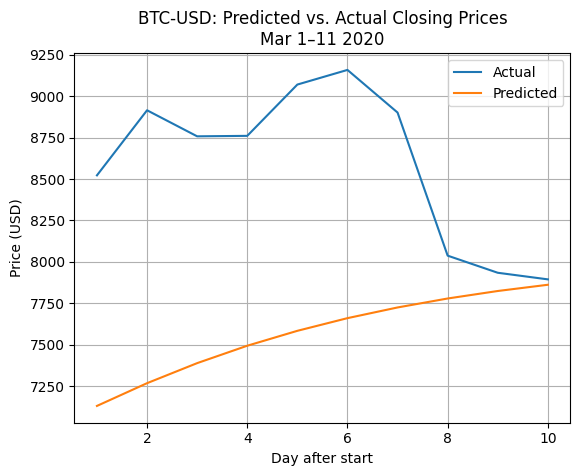

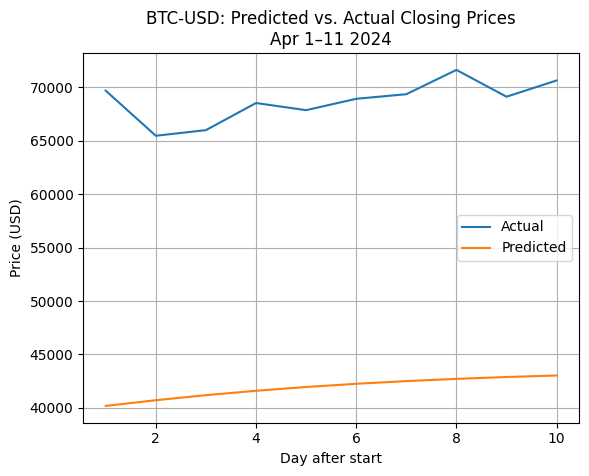

In [ ]:
def plot_prediction_vs_actual(actual, predicted, title):
    """
    Plots actual vs. predicted values over the same x-axis (days 1…N).
    
    Parameters:
    actual: list or array of actual values
    predicted: list or array of predicted values
    title: string plot title
    """
    # x-axis: 1, 2, …, N
    days = list(range(1, len(actual) + 1))
    
    plt.figure()
    plt.plot(days, actual, label="Actual")
    plt.plot(days, predicted, label="Predicted")
    plt.xlabel("Day after start")
    plt.ylabel("Price (USD)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for March 2020
plot_prediction_vs_actual(
    actual=actual_prices_10daysMar2020,
    predicted=predicted_price60daylow_n,
    title="BTC-USD: Predicted vs. Actual Closing Prices\nMar 1–11 2020"
)

# Example for April 2024
plot_prediction_vs_actual(
    actual=actual_prices_10daysApr2024,
    predicted=predicted_price60dayhigh_n,
    title="BTC-USD: Predicted vs. Actual Closing Prices\nApr 1–11 2024"
)


---

# 9. Conclusion

The model results were not very promising under the mean squared error loss function and Adam optimizer. 
Another iteration could be done with different loss functions like mean absolute error or huber, which are robust to outliers and less sensitive to extreme deviations and that heavily penalize models .
Two optimizers which could better pick up on noise and nonlinear patterns are `rmsprops` and `nadam` because the current optimizer Adam may struggle to adaptively with tuning nonstationary price shocks or chaotic volatility. 

To change these parameters and tune the model, the defaults would have to be changed in the python functions. 
Another factor to keep in mind is the two cases graphed above are extremely volatile bitcoin trends that are known as historical lows and highs around COVID-19 and a Bitcoin hype rally in 2024, therefore they would be tricky even for a well tuned model. 

This app additionally launches a websocket that listens for trade data from both Binance and Coinbase to do a sliding window anomoly detection. It runs automatically as soon as the docker compose is ran. The user can monitor the logs in the terminal or using the Flower UI that is connected at localhost:5555. This live steam could be used to implement batch handling LSTM predictions which would be closer to a live analysis. I will continue to tune the models and incorporate the live stream.

If this is your first RNN, congratulations, this was also my first RNN and pipeline too. 